# Movie Recommendation System

### Dataset: [Movie Lens Small Latest Dataset](https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset)

## Reading Kaggle Data

We started with reading in the data from the Kaggle dataset into four Pandas DataFrames.

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

movies_df = pd.read_csv('archive/movies.csv')
ratings_df = pd.read_csv('archive/ratings.csv')
tags_df = pd.read_csv('archive/tags.csv')
links_df = pd.read_csv('archive/links.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


**movies_df**: movieId, title, genres

This DataFrame contains information on the movie and movie type.

In [285]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [286]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**ratings_df**: userId, movieId, rating, timestamp

This DataFrame contains all of the ratings for movies provided by the users, along with the timestamp of the rating. The ratings themselves are made on a 5-star scale in half-star increments (0.5 stars - 5.0 stars).

In [287]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


**tags_df**: userId, movieId, tag, timestamp

This DataFrame contains the tags given to movies by users, usually single words or short phrases, along with the timestamp of these tags.

In [288]:
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


**links_df**: movieId, imdbId, tmdbId

This DataFrame contains identifiers that can be used to link to other sources of movie data, namely IMDB and TMDB.

## Feature Engineering

### links_df

Because we are not dealing with other sources of movie data, we do not need to use any of the data contained in the links_df dataframe.

### tags_df

For the tags_df, we wanted to look at how many tags the movies had in common versus how many were unique.

In [289]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [290]:
tags_df.tag.apply(str.lower).value_counts()

in netflix queue     131
atmospheric           41
surreal               24
thought-provoking     24
funny                 24
                    ... 
up series              1
emma thompson          1
macaulay culkin        1
plastic surgery        1
a clever chef rat      1
Name: tag, Length: 1475, dtype: int64

Given how few tags there were in common between the many movies in the dataset, we decided that the tags would not be useful to consider for our recommendation system.

### movie_df

Next, we will use one-hot encoding to split the movies_df _genres_ column into one column for every possible genre to help visualize the movie data.

In [291]:
genre_labels = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'IMAX', '(no genres listed)']

movies_df[genre_labels] = 0
for i in range(len(movies_df)):
    row = movies_df.iloc[i,:]
    genres = row['genres'].split('|')
    for genre in genres:
        movies_df.loc[i, genre] = 1
movies_df.drop(columns=['genres'], inplace=True, axis=1)
movies_df

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### ratings_df

Now, we want to clear up the data in the ratings dataframe. Instead of one row for every rating, we wanted to have a clearer look at the individual users and what ratings they gave for each movie. To do this, we created a new dataframe where each column represents each unique userId and each row represents each unique movieId.

In [292]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [293]:
user_movie_ratings = ratings_df.pivot(index='movieId',columns='userId',values='rating')
user_movie_ratings.fillna(0,inplace=True)
user_movie_ratings

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For every cell where a user did not leave a rating for a movie, we filled in the cell with 0.0.

We decided that this dataframe is the most useful for recommending new movies because it correlates users with movies that they have rated through the columns along with correlating the users that have rated movies similarly through the rows. From there we can extrapolate which ones would be best suited as new recommendations for the user using a version of collaborative filtering.

So, our next step is to continue cleaning up the dataframe. First we want to look at the number of ratings each movie has gotten and the number of ratings each user has given.

In [294]:
n_movie_ratings = ratings_df.groupby('movieId')['rating'].agg('count')
n_user_ratings = ratings_df.groupby('userId')['rating'].agg('count')
print("Number of ratings each movie has gotten:\n", n_movie_ratings)
print()
print("Number of ratings each user has given:\n", n_user_ratings)

Number of ratings each movie has gotten:
 movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

Number of ratings each user has given:
 userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


In [295]:
n_movie_ratings.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

The minimum number of ratings given to a movie is 1, which is useless to the recommendation system because it only takes into account the opinion of one user rather than many and is not very credible. As a threshold, we chose 16, which is halfway between the mean and the standard deviation, and is a reasonable number of ratings for one movie to be credible and leaves us with enough movies to have a comprehensive recommendation system.

In [296]:
# number of movies left after threshold cutoff
movie_threshold = 16
len([i for i in n_movie_ratings if i > movie_threshold])

1498

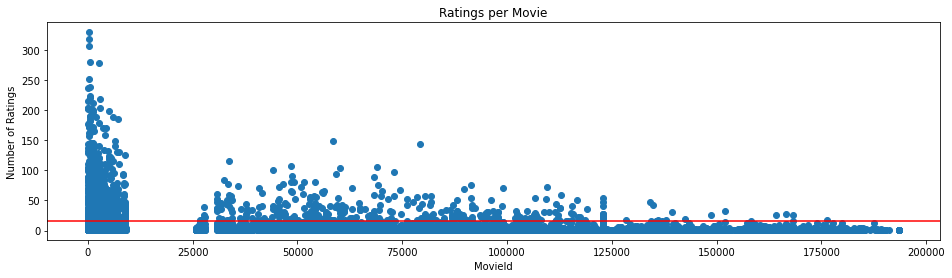

In [297]:
plt.subplots(1,1,figsize=(16,4))
plt.scatter(n_movie_ratings.index, n_movie_ratings)
plt.axhline(y=movie_threshold, color='r')
plt.xlabel('MovieId')
plt.ylabel('Number of Ratings')
plt.title('Ratings per Movie')
plt.show()

In [298]:
n_user_ratings.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

Here, the minimum number of movies that one user has rated is 20, while the maximum is 2698 and the mean is 165. Given how many movies the majority of the users have rated, 20 is also too small of a number to provide useful data for our recommendation system. Because there are not as many users in this dataset, however, instead of finding a number between the mean and standard deviation, we chose 60. This is because this is a relatively reasonable number of movies for a user to have seen and reviewed to get a good sense of their preferences but still doesn't reduce the data too much.

In [299]:
# number of users left after threshold cutoff
user_threshold = 60
len([i for i in n_user_ratings if i > user_threshold])

334

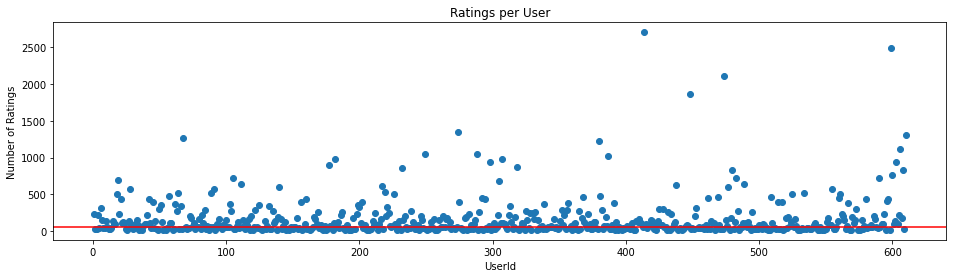

In [300]:
plt.subplots(1,1,figsize=(16,4))
plt.scatter(n_user_ratings.index, n_user_ratings)
plt.axhline(y=user_threshold, color='r')
plt.xlabel('UserId')
plt.ylabel('Number of Ratings')
plt.title('Ratings per User')
plt.show()

Now, by reducing some of the noise in the data, hopefully we will get a more accurate model.

In [301]:
df = user_movie_ratings.loc[n_movie_ratings[n_movie_ratings > movie_threshold].index,:]
df = df.loc[:,n_user_ratings[n_user_ratings > user_threshold].index]
df

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152081,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
164179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
166528,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


## KNN Algorithm

Now that our data is ready, now we will move onto creating our algorithm. We chose the K-Nearest Neighbors algorithm because we wanted our system to be based on finding the similarities between the movies and the ratings given to them by users, not necessarily categorizing them by any of their features. We knew that KNN is insensitive to outliers, which our data may have quite a few of based on the graphs above, and there are also no set decision boundaries and the output is easy to interpret as a list of movies. We considered random forest, but we know that algorithm is more sensitive to outliers and to noisy datasets, and we did not want to run the risk of overfitting to any of our data.

In [302]:
knn = NearestNeighbors(n_neighbors=20)
knn.fit(df)

NearestNeighbors(n_neighbors=20)

In [303]:
def recommend_n_movies(df, movie_name, n):
    # get a list of all of the movies with the movie name in the title
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]
    # if the movie doesn't exist in the data, we cannot provide a recommendation
    if len(movie_list):
        movie_id = movie_list.iloc[0]['movieId']
        if (df.index == movie_id).any():
            distances, indices = knn.kneighbors(df.loc[movie_id:movie_id, :], n_neighbors=n + 1)
            rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())), key=lambda x: x[1])[1:]
            recommendations = []
            for val in rec_movie_indices:
                recommendations.append({'Title':movies_df.iloc[val[0]]['title'],'Distance':val[1]})
            movies = pd.DataFrame(recommendations, index=range(1, n + 1))
            return movies
    return "Movie not found in database."

In [304]:
recommend_n_movies(df, "Iron Man", 10)

,Title,Distance
1,Kurt & Courtney (1998),24.515301
2,Small Soldiers (1998),24.545875
3,He Got Game (1998),26.286879
4,Music From Another Room (1998),26.358111
5,Shooting Fish (1997),26.448062
6,High Art (1998),26.897955
7,Primary Colors (1998),27.166155
8,Prom Night IV: Deliver Us From Evil (1992),27.454508
9,Mrs. Dalloway (1997),27.490908
10,"Gingerbread Man, The (1998)",27.513633


These results did not make a lot of sense to us, so we took another look at our data and realized that most of the values in the dataframe are zeros. We were thinking that this may throw off our model and cause these random recommendations. To fix this, we did some research and found a package from the scipy library that deals with sparse values.

In [305]:
csr_data = csr_matrix(df.values)
df_reduced = df.reset_index()

In [306]:
df_reduced

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,152081,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1494,164179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1495,166528,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1496,168252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [307]:
knn = NearestNeighbors(n_neighbors=20)
knn.fit(csr_data)

NearestNeighbors(n_neighbors=20)

In [308]:
def recommend_n_movies(df, movie_name, n):
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_id = movie_list.iloc[0]['movieId']
        if (df.movieId == movie_id).any():
            movie_id = df[df['movieId'] == movie_id].index[0]
            distances , indices = knn.kneighbors(csr_data[movie_id],n_neighbors=n + 1)    
            rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())), key=lambda x: x[1])[1:]
            recommendations = []
            for val in rec_movie_indices:
                movie_id = df.iloc[val[0]]['movieId']
                idx = movies_df[movies_df['movieId'] == movie_id].index
                recommendations.append({'Title':movies_df.iloc[idx]['title'].values[0], 'Distance':val[1]})
            movies = pd.DataFrame(recommendations, index=range(1, n + 1))
            return movies
    return "Movie not found in database."

In [309]:
recommend_n_movies(df_reduced, "Iron Man", 10)

,Title,Distance
1,Iron Man 2 (2010),24.515301
2,"Avengers, The (2012)",24.545875
3,Avatar (2009),26.286879
4,Watchmen (2009),26.358111
5,Kung Fu Panda (2008),26.448062
6,Thor (2011),26.897955
7,Star Trek (2009),27.166155
8,Guardians of the Galaxy (2014),27.454508
9,Pirates of the Caribbean: At World's End (2007),27.490908
10,Sherlock Holmes (2009),27.513633


These results make a lot more sense, knowing what the Iron Man movie is about and the similarities it has to the movies in this new list. Below are more examples of our recommendation system working.

In [310]:
recommend_n_movies(df_reduced, "Jumanji", 10)

,Title,Distance
1,Casper (1995),29.782545
2,Ace Ventura: When Nature Calls (1995),31.232995
3,Dragonheart (1996),31.249000
4,Pocahontas (1995),31.320920
5,Home Alone (1990),31.468238
6,"Honey, I Shrunk the Kids (1989)",31.519835
7,"Santa Clause, The (1994)",31.539658
8,Waterworld (1995),31.599051
9,Cliffhanger (1993),31.674122
10,Beverly Hills Cop III (1994),31.721444


In [311]:
recommend_n_movies(df_reduced, "Snow White", 5)

,Title,Distance
1,Pinocchio (1940),24.545875
2,Cinderella (1950),25.119713
3,"Little Mermaid, The (1989)",26.057628
4,Peter Pan (1953),26.348624
5,"Aristocats, The (1970)",26.462237


In [312]:
recommend_n_movies(df_reduced, "Matrix", 20)

,Title,Distance
1,Fight Club (1999),38.942265
2,Saving Private Ryan (1998),41.152157
3,Star Wars: Episode V - The Empire Strikes Back...,41.364236
4,Star Wars: Episode VI - Return of the Jedi (1983),42.608685
5,"Sixth Sense, The (1999)",43.243497
6,Gladiator (2000),43.954522
7,Star Wars: Episode IV - A New Hope (1977),44.008522
8,"Lord of the Rings: The Fellowship of the Ring,...",44.110656
9,Memento (2000),44.659825
10,"Lord of the Rings: The Return of the King, The...",44.715769


Below are examples of when the movie does not exist or the number of ratings does not meet the threshold.

In [313]:
recommend_n_movies(df_reduced, "Captain America", 10)

'Movie not found in database.'

In [314]:
recommend_n_movies(df_reduced, "does not exist", 5)

'Movie not found in database.'

In [315]:
recommend_n_movies(df_reduced, "Wonder Woman", 5)

'Movie not found in database.'